In [22]:
import warnings

warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [38]:
import scanpy as sc
import scipy as sci
import matplotlib.pyplot as plt
import numpy as np

sc.set_figure_params(figsize=(6, 6), frameon=False) # pyright: ignore[reportArgumentType]
sc.settings.n_jobs = 2

In [24]:
adata = sc.read_10x_mtx(
    path="./data/filtered_gene_bc_matrices/hg19/",
    var_names="gene_symbols", 
    cache=True,
)

adata.var_names_make_unique() 
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [25]:
sc.pp.filter_cells(adata, min_genes=200) # get rid of cells with less than 200 genes
sc.pp.filter_genes(adata, min_cells=3)   # get rid of genes with less than 3 cells

adata

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'

In [26]:
# create a new column named "mt" of bool type which tells whether that gene is mitochondrial gene or not
adata.var["mt"] = adata.var_names.str.startswith("MT-")
mt_genes = adata.var[adata.var["mt"]]
mt_genes

,gene_ids,n_cells,mt
MT-ND1,ENSG00000198888,2558,True
MT-ND2,ENSG00000198763,2416,True
MT-CO1,ENSG00000198804,2686,True
MT-CO2,ENSG00000198712,2460,True
MT-ATP8,ENSG00000228253,32,True
MT-ATP6,ENSG00000198899,2014,True
MT-CO3,ENSG00000198938,2647,True
MT-ND3,ENSG00000198840,557,True
MT-ND4L,ENSG00000212907,398,True
MT-ND4,ENSG00000198886,2588,True


In [27]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
adata.obs

,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
AAACATACAACCAC-1,781,779,2419.0,73.0,3.017776
AAACATTGAGCTAC-1,1352,1352,4903.0,186.0,3.793596
AAACATTGATCAGC-1,1131,1129,3147.0,28.0,0.889736
AAACCGTGCTTCCG-1,960,960,2639.0,46.0,1.743085
AAACCGTGTATGCG-1,522,521,980.0,12.0,1.224490
...,...,...,...,...,...
TTTCGAACTCTCAT-1,1155,1153,3459.0,73.0,2.110436
TTTCTACTGAGGCA-1,1227,1224,3443.0,32.0,0.929422
TTTCTACTTCCTCG-1,622,622,1684.0,37.0,2.197150
TTTGCATGAGAGGC-1,454,452,1022.0,21.0,2.054795


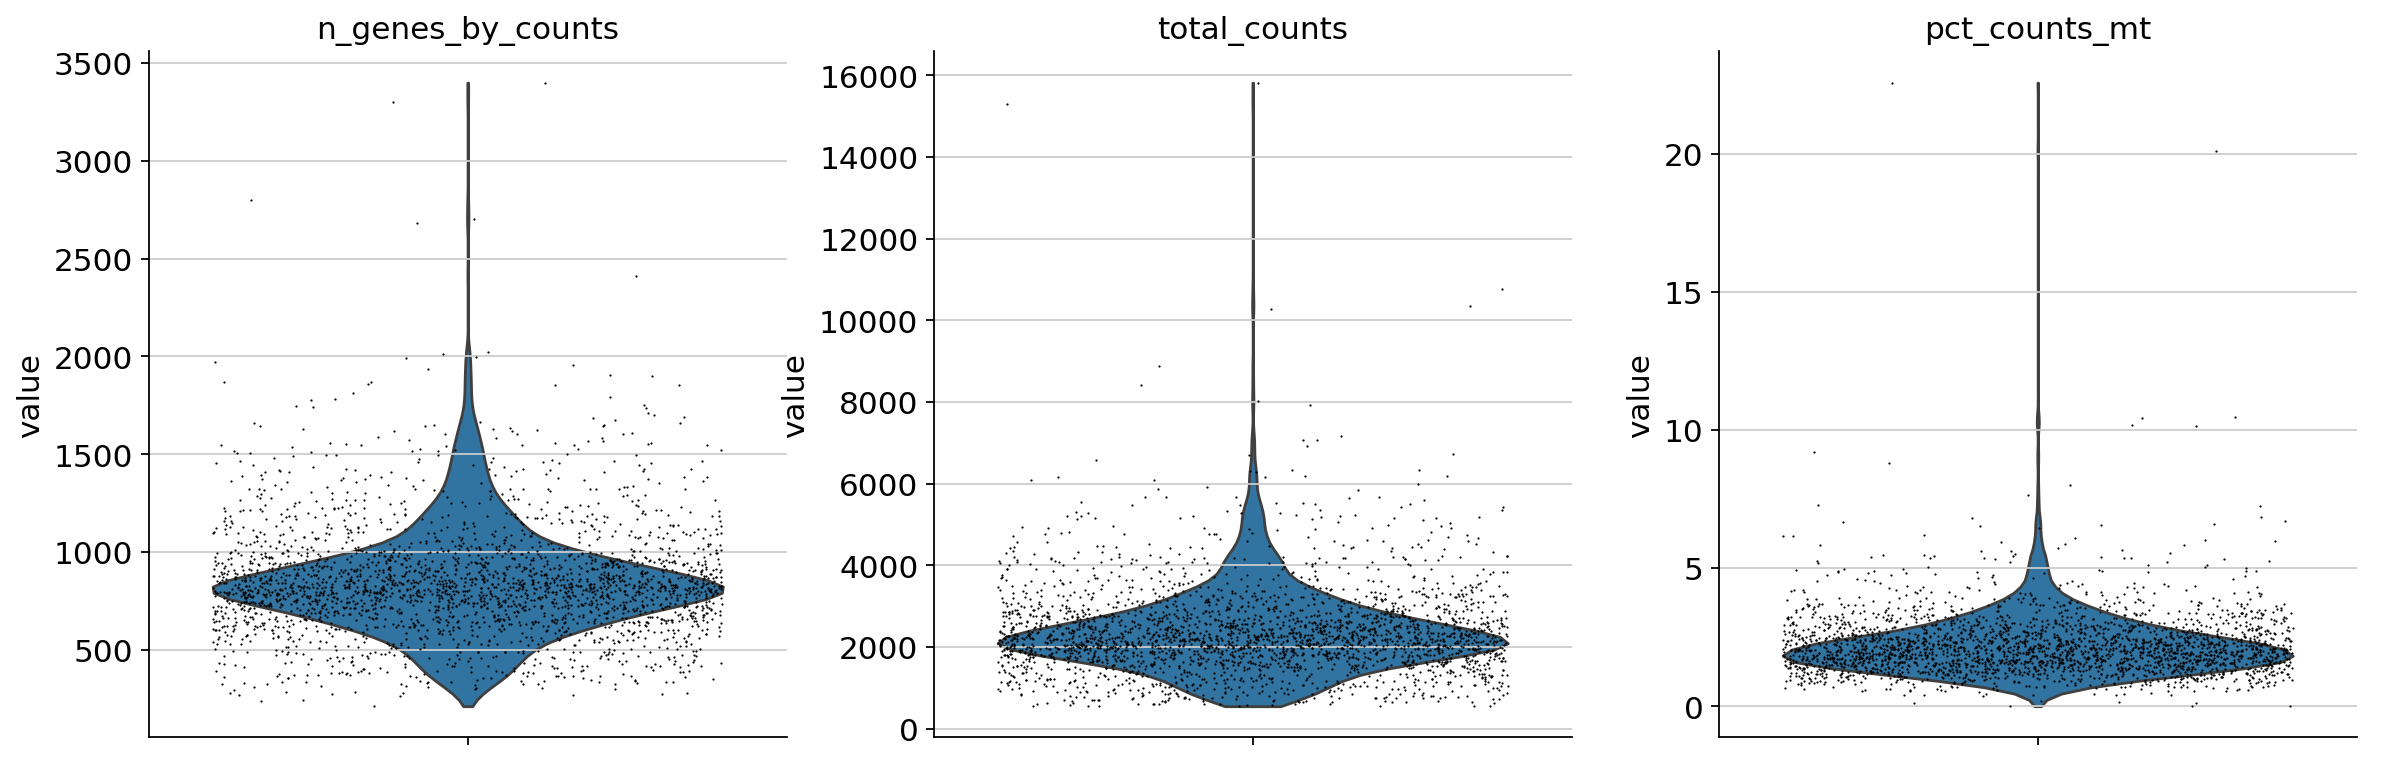

In [28]:
sc.pl.violin(adata, ["n_genes_by_counts", "total_counts", "pct_counts_mt"], multi_panel=True, jitter=0.4)

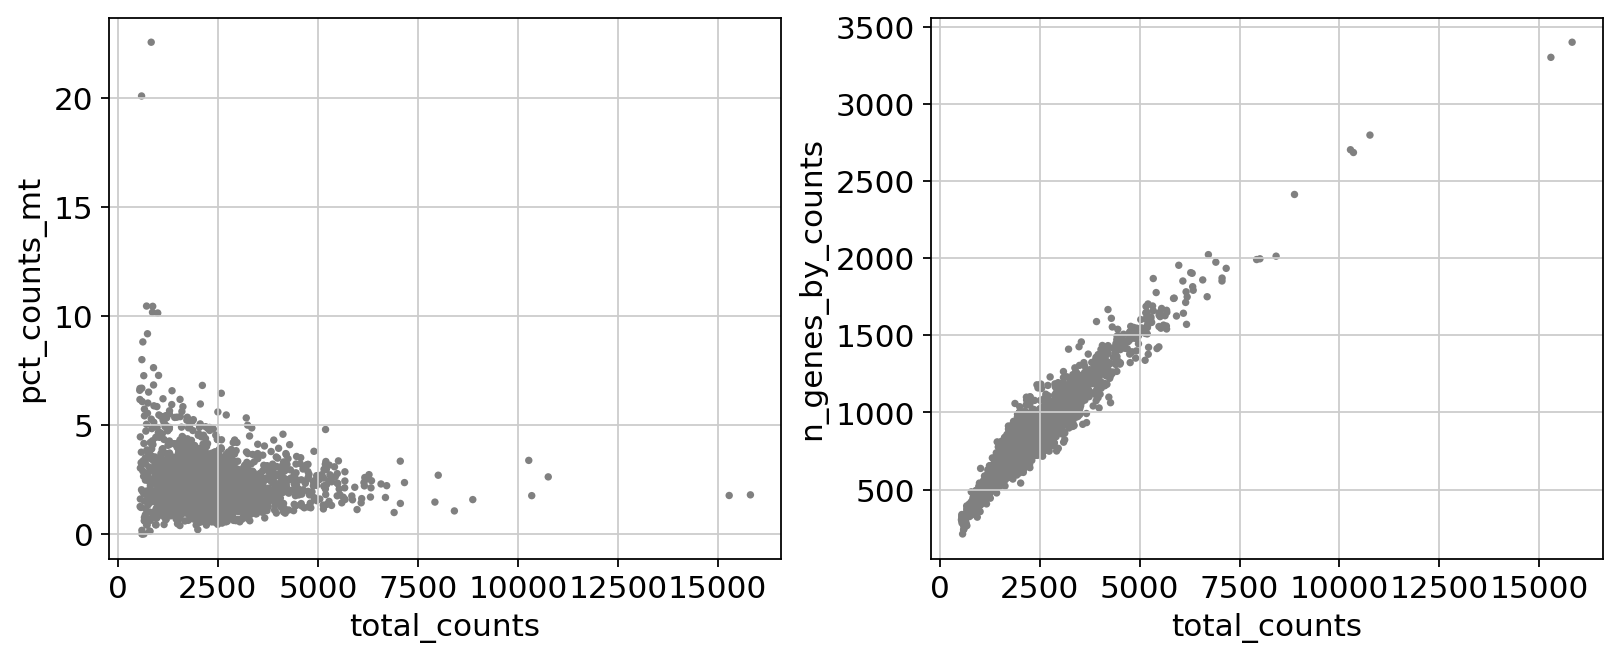

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")

sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1])

plt.show()

In [30]:
upper_lim = np.quantile(adata.obs["n_genes_by_counts"].to_numpy(), .97)
lower_lim = np.quantile(adata.obs["n_genes_by_counts"].to_numpy(), .03)

In [31]:
# dataset is filtered using thresholding 
# if there are too few genes then either the cell has low RNA content or else it is an empty droplet
# if there are too many genes then it might be a double droplet
# if % of mitochondrial genes is high then it might be indicative of cytoplasmic mRNA leaking through a broken membrane

adata = adata[
    (adata.obs["n_genes_by_counts"] < upper_lim)
    & (adata.obs["n_genes_by_counts"] > lower_lim)
    & (adata.obs["pct_counts_mt"] < 5),
    :,
].copy() 

adata

AnnData object with n_obs × n_vars = 2497 × 13714
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [32]:
# normalizing such that each cell has 10k reads and converting to log counts stabilizes the variance by squeezing the large values and spreading 
# the smaller values

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [34]:
# identifying the highly variable genes

sc.pp.highly_variable_genes(
    adata,
    # layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

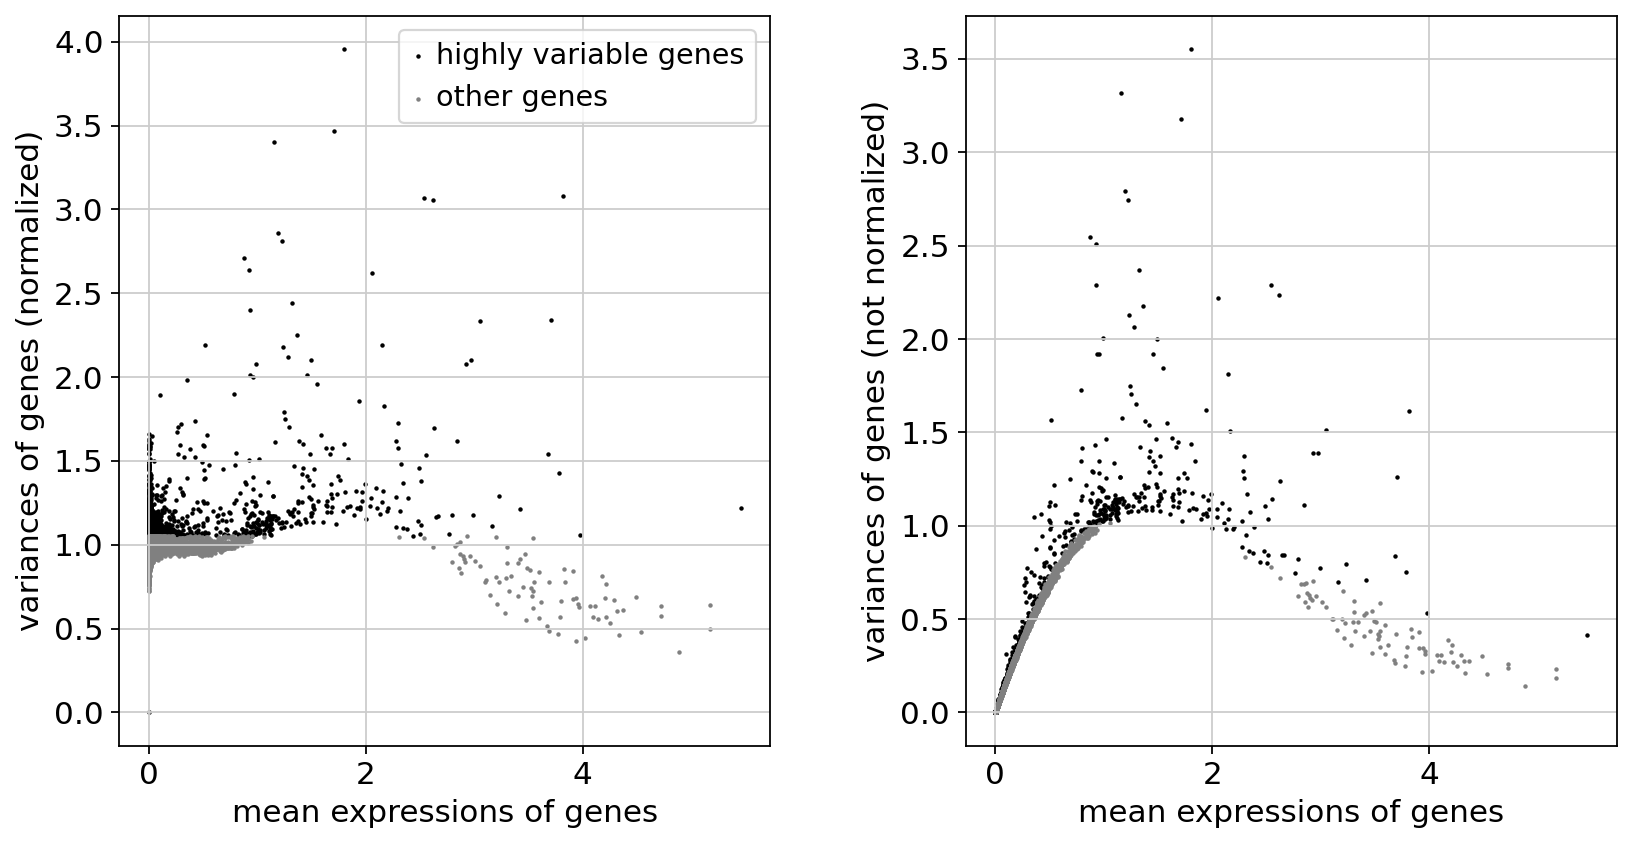

In [35]:
sc.pl.highly_variable_genes(adata)

In [40]:
adata.layers["scaled"] = adata.X.toarray() # pyright: ignore[reportOptionalMemberAccess, reportAttributeAccessIssue]
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")